## Reddit EC detection

In [19]:
import os
import glob
import json
import pickle

import datetime
import operator
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
# from cdlib import AttrNodeClustering, evaluation, TemporalClustering
# from Eva import eva_best_partition, modularity, purity
from collections import defaultdict
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.lines as mlines
sns.set_palette("Set2")

sns.set_style(style='white')

## Functions

In [20]:
def map_labels(g):
    comps_list = list(nx.connected_components(g))
    max_len = sorted([[len(el),el] for el in comps_list], reverse=True)
    comp_0 = nx.subgraph(g, max_len[0][1])
    mapping = dict(zip(comp_0, range(0, len(comp_0))))
    relabel_comp_0 = nx.relabel_nodes(comp_0, mapping)
    inv_map = {v: k for k, v in mapping.items()}

    return relabel_comp_0, inv_map


def load_json(file):
    '''Load a json file'''
    with open(file) as f:
        json_data = json.loads(f.read())
    return json_data

def read_net(filename):
    print("\nEdgelist: ", filename)
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g

def read_labels(filename):
    node_to_label = {}
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.rstrip().split(",")
            node_to_label[l[0]] = l[2]
    return node_to_label

def purity_func(coms, labels):
    count_coms = defaultdict(int)
    purities =[]
    top_label = []
    # scorro i nodi + coms associata
    for n, c in coms.items():
        # salvo il numero di persone in ciascuna com
        count_coms[c] += 1
    #per ogni coms    
    for el in labels: 
        #prendo il valore della max label
        max_label = max(labels[el]["leaning"].items(), key = operator.itemgetter(1))[0]
        # prendo la frequenza della etichetta più ricorrente
        max_label_val = labels[el]["leaning"][max_label]
        purity = max_label_val/count_coms[el]
        purities.append(purity)
        top_label.append(max_label)
    return purities, top_label
    

In [21]:
categories = ["guncontrol", 'minority', "politics"]
semesters = [('01/01/2017','01/07/2017'), ('01/07/2017','01/01/2018'),
             ('01/01/2018','01/07/2018'), ('01/07/2018','01/01/2019'), ('01/01/2019','01/07/2019')]

In [22]:
src_results = "../results/reddit_results/"
text_data = "../text_data/"

In [23]:
jaccard = lambda x, y:  len(set(x) & set(y)) / len(set(x) | set(y))

In [24]:
mods = load_json("../data/moderators.json")
bots = load_json("../data/bots_reddit.json")

In [25]:
mods_bots_list = []
mods_list = [k for k in mods.keys()]
bots_list = [k for k in bots.keys()]
   
mods_bots_list = mods_list + bots_list


In [26]:
def cd_eva(node_label):
    coms, com_labels = eva_best_partition(node_label, alpha=0.5)
    return coms, com_labels

In [27]:
def extract_EC(categories):
    
    matches_dict = defaultdict(list)
    
    for topic in tqdm(categories):
        tc = TemporalClustering()
        #etichetta del semestre per ogni categoria 
        sem = 0
        data_path = f"../tesi_cau/topic_networks/{topic}/"
        
        for semester in semesters:
            # estraggo gli anni per avere i path per trovare i file corretti
            period0_nodelist= datetime.datetime.strptime(semester[0], "%d/%m/%Y").strftime("%d-%m-%Y")
            period1_nodelist = datetime.datetime.strptime(semester[1], "%d/%m/%Y").strftime("%d-%m-%Y")
            
            period0_labels= datetime.datetime.strptime(semester[0], "%d/%m/%Y").strftime("%Y-%m-%d")
            period1_labels = datetime.datetime.strptime(semester[1], "%d/%m/%Y").strftime("%Y-%m-%d")
            
            semester_edgelist = os.path.join(data_path, f'{topic}_{period0_nodelist}_{period1_nodelist}_complete.csv')
            
            semester_labels = os.path.join(data_path, f'{topic}_{period0_labels}_{period1_labels}_labels.csv') 
            #una volta preso il file, edgelist.csv, mi creo la rete
            g = read_net(semester_edgelist)
            nth = read_labels(semester_labels) # recupero il LEANING
            nx.set_node_attributes(g, nth, "leaning")
            nx.set_node_attributes(g, sem, "snapshot_id")
            
            # check if there are nodes without leaning (avoid eva division by 0)
            nodes_to_remove = list()
            for node in g.nodes:
                node_dict = g.nodes[node]
                if node_dict.get('leaning') is None:
                    nodes_to_remove.append(node)
                if node in mods_bots_list:
                    nodes_to_remove.append(node)
                    
            g.remove_nodes_from(nodes_to_remove)
            
            
            print("Network info: ", nx.info(g))
            relabel, mapping = map_labels(g)
            coms, labels = cd_eva(relabel)

            coms_to_node = defaultdict(list)
            for n, c in coms.items():
                coms_to_node[c].append(n)
            
            coms_eva = [list(c) for c in coms_to_node.values()]
            
    
            eva_attr_node_clustering = AttrNodeClustering(coms_eva, relabel, "Eva", labels, method_parameters={"weight": 'weight', "resolution": 1,
                                                                             "randomize": False, "alpha":0.5})
            
            tc.add_clustering(eva_attr_node_clustering, sem)
            print(f"Numero community timestamp t{sem}: ", len(tc.get_clustering_at(sem).communities)) 
            
#             with open(os.path.join(src_results, f"res_{topic}_{sem}.pickle"), 'wb') as f:
#                 pickle.dump(eva_attr_node_clustering, f, protocol=pickle.HIGHEST_PROTOCOL)
            eva_comm = list()
            for com in eva_attr_node_clustering.communities:
                each_com = list()
                for node in com:
                    each_com.append(mapping[node])
                eva_comm.append(each_com)
            
            # build a list of labels for the coms for the EVA evaluation df and the user ids df
            df_label_coms = []
            user_coms = {}
            for el in range(len(eva_comm)):
                df_label_coms.append(f"{sem}_{el}")
                for user in eva_comm[el]:
                    user_coms[str(user)] = f"{sem}_{el}"       
                        
            df_user_coms = pd.DataFrame(user_coms, index=["community",]).T.rename_axis('user_id').reset_index()
            df_user_coms.to_csv(os.path.join(src_results, f"snapshots/users_community_{topic}_t_{sem}.csv"),
                            index = False)
            
            print("--- Saving EVA results ---")
            eva_results = pd.DataFrame()
            size = evaluation.size(relabel, eva_attr_node_clustering, summary=False)
            avg_internal_deg = evaluation.average_internal_degree(relabel, eva_attr_node_clustering, summary=False)
            int_edge_dens = evaluation.internal_edge_density(relabel, eva_attr_node_clustering, summary=False)
            conductance = evaluation.conductance(relabel, eva_attr_node_clustering, summary=False)
            cut_ratio = evaluation.cut_ratio(relabel, eva_attr_node_clustering, summary=False)
            link_modularity = evaluation.link_modularity(relabel, eva_attr_node_clustering, summary=False)
            edge_inside = evaluation.edges_inside(relabel, eva_attr_node_clustering,summary=False)
            purity, max_label = purity_func(coms, labels)
            eva_results['purity'] = purity
            eva_results["max_label"] = max_label
            eva_results['internal_edge_density'] = int_edge_dens
            eva_results['average_internal_degree'] = avg_internal_deg
            eva_results['conductance'] = conductance
            eva_results['cut_ratio'] = cut_ratio
            eva_results['edge_inside'] = edge_inside
            eva_results['size'] = size
            eva_results["timestamp"] = sem
            eva_results["community"] = df_label_coms 

#             print(df_user_coms)
            eva_results.to_csv(os.path.join(src_results, f"snapshots/eva_snapshot_{topic}_{sem}_com_stats.csv"), index = False)
            
            eva_users_stats = pd.merge(left=eva_results, right = df_user_coms, left_on="community",
                                       right_on = "community" , how = "outer")
            
            eva_users_stats.to_csv(os.path.join(src_results, f"{topic}/eva_users_merged_{sem}_com_stats.csv"), index = False)
            ec = eva_results.loc[(eva_results['purity'] >= 0.7) & (eva_results['conductance'] <= 0.5)].copy()
            ec.to_csv(os.path.join(src_results, f"{topic}/EC/EC_{topic}_{sem}.csv"), index = False)

            not_ec = eva_results.loc[((eva_results['purity'] < 0.7) & (eva_results['conductance'] >= 0.5) | 
                                  (eva_results['purity'] < 0.7) |(eva_results['conductance'] > 0.5)   ) ].copy()
            not_ec.to_csv(os.path.join(src_results, f"{topic}/non_EC/non_EC_{topic}_{sem}.csv"), index = False)
            sem += 1

            
        matches = tc.community_matching(jaccard, two_sided=False)
        matches_dict[topic] = matches
        
     #    print("\n", matches)
    with open(os.path.join(src_results, f"matches_dict.pickle"), 'wb') as r:
        pickle.dump(matches_dict, r, protocol=pickle.HIGHEST_PROTOCOL)
    
    return matches_dict
        


In [28]:
# for topic in tqdm(categories):
#     print("Communities distinction for topic {}".format(topic))
#     df_list = list()
#     df_list_ec = list()
#     # df_users = list()
#     for i in range(5):
#         temp_df_not_ec = pd.read_csv(os.path.join(src_results, f"{topic}/Non_EC/Non_EC_{topic}_{i}.csv"))
#         df_list.append(temp_df_not_ec)

#         temp_df_ec = pd.read_csv(os.path.join(src_results, f"{topic}/EC/EC_{topic}_{i}.csv"))
#         df_list_ec.append(temp_df_ec)

#     non_ec_info = pd.concat(df_list, ignore_index = True)
#     ec_info = pd.concat(df_list_ec, ignore_index = True)

#     top_non_ecs = non_ec_info[((non_ec_info['conductance'] >= 0.5) & (non_ec_info['purity'] >= 0.7))
#                                    | ((non_ec_info['conductance'] <= 0.5) & (non_ec_info['purity'] <= 0.7))
#                                    | ((non_ec_info['conductance'] >= 0.5) & (non_ec_info['purity'] <= 0.7))]
    
#     top_non_ecs.to_csv(os.path.join(src_results, f"{topic}/df_complete_not_EC_{topic}.csv"), index = False)

#     top_ecs = ec_info[((ec_info['conductance'] < 0.5) & (ec_info['purity'] >= 0.7)) & (ec_info['size'] >= 20) ]  
#     top_ecs.to_csv(os.path.join(src_results, f"{topic}/df_complete_EC_{topic}.csv"), index = False)


In [29]:
# matches = extract_EC(categories)

In [32]:
with open(os.path.join(src_results, f"matches_dict.pickle"), 'rb') as input_file:
    matches = pickle.load(input_file)

In [33]:
matches = defaultdict(list)
for topic in tqdm(categories):
    #etichetta del semestre per ogni categoria 
    sem = 0
    print(topic)
    lifecycle = []
    for i in range(5):
        if i != 4:
            # estraggo gli anni per avere i path per trovare i file corretti
            df_t0 = pd.read_csv(f"../results/reddit_results/{topic}/eva_users_merged_{i}_com_stats.csv")
            df_t1 = pd.read_csv(f"../results/reddit_results/{topic}/eva_users_merged_{i+1}_com_stats.csv")
            user_list_t0 = df_t0.user_id.tolist()
            user_list_t1 = df_t1.user_id.tolist()
            intersection = [user for user in user_list_t0 if user in user_list_t1]
            df_t0_clean = df_t0[df_t0["user_id"].isin(intersection)]
            df_t1_clean = df_t1[df_t1["user_id"].isin(intersection)]
            dict_com = defaultdict(list)
            dict_com_t1 = defaultdict(list)
            for com in df_t0_clean.community.unique():
                com_df = df_t0_clean[df_t0_clean["community"]== com]
                dict_com[com] = com_df.user_id.tolist()
            for com in df_t1_clean.community.unique():
                com_df = df_t1_clean[df_t1_clean["community"]== com]
                dict_com_t1[com] = com_df.user_id.tolist()   
            for name_i, com_i in dict_com.items():
                best_match = []
                best_score = 0
                for name_j, com_j in dict_com_t1.items():
                    match = jaccard(com_i, com_j)
                    if match > best_score:
                        best_match = [name_j]
                        best_score = match
                    elif match == best_score:
                        best_match.append(name_j)
                for j in best_match:
                    lifecycle.append((name_i, j, best_score))
                    
        matches[topic] = lifecycle
        

  0%|          | 0/3 [00:00<?, ?it/s]

guncontrol
minority
politics


In [34]:
def temporal_stability(community, topic):
    dict_stability = defaultdict(list)
    dict_labels = defaultdict(list)
    actual_com = community
    
    for i in range(len(matches[topic])):
        stability = []
        plot_labels = []
        timeline =[]
        #similarità al t1
        if matches[topic][i][0] == actual_com:
            stability.append(matches[topic][i][2])
            actual_com = matches[topic][i][1]
            timeline.append(community)
            timeline.append(actual_com)
            j = i + 1
#         plot_labels.append(u[0])
#         v_prec = v
#         timeline.append(v_prec)
#         j = i+ 1 #inizio a scorrere la lista dal successivo
            while j <= len(matches[topic])-1:
    #                 #se il primo el (quindi skippo di riga) è identico al precedente
                if (matches[topic][j][0] == actual_com):
                    stability.append(float(matches[topic][j][2]))
    #                 plot_labels.append(matches[topic][j][0][0])
                    actual_com = matches[topic][j][1]
                    timeline.append(actual_com)
    #             print(timeline)
                j += 1
                
            return stability, timeline
           

   
import matplotlib.lines as mlines

def get_color(df, key): 
    leaning_key = (df.max_label[df["community"]==key].item())
    if(leaning_key == "antitrump"):
        color = "#07264e"
    else: 
        color = "#ae1f23"
    return color

def ec_marker(timeline, ec_val): 
    marker_dict = {}
    for com in timeline:
        if (com in ec_val):
            marker_dict[com] = '^'
        else:
            marker_dict[com] = '.'
    return marker_dict
    
def get_marker(marker_dict, point_list):
    marker = []
    for point in point_list: 
        marker.append(marker_dict[point])
    print(marker)
    return marker[:-1]

def get_labels(timeline):
    labels = []
    for el in range(len(timeline)-1):
        label = ' - '.join([timeline[el], timeline[el+1]])
        labels.append(label)
    return labels

In [35]:
def plot_EC_stability(categories, ec_val):
    for topic in tqdm(categories):
        df_list = list()
       
        df = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"))
        #retrieve non_ecs or ecs    
        df["topic"] = topic
        #which is the stability of communities ECs?  
        ec_list = df.community.tolist()
        communities = df.community.tolist()
        print(communities)
        for com in communities:
            #if com.startswith('0'):
            if not com.startswith('4'):
                # the coms labels at t0 are the input for temporal_stability () 
                stability, timeline = temporal_stability(com, topic, communities) # are ECs stable over time?
                marker_dict = ec_marker(timeline, ec_val)
                marker_list = get_marker(marker_dict, timeline)
                timeline_labels = get_labels(timeline)
                # fig, ax = plt.subplots(1,1,figsize=(12,8))
                
                # plt.plot(stability, linewidth=2.5, c= "k",alpha = 0.3)
                
                # for i in range(0,len(stability)):
                #     if marker_list[i] == "^":
                #         ax.scatter(timeline_labels[i], stability[i], 
                #                    marker='^', label="EC", alpha = 0.5, s = 90, c = "#ff7f0e")
                #     else:
                #         ax.scatter(timeline_labels[i], stability[i], 
                #                    marker='.', label='Not EC', alpha = 0.5, s = 90, c = "#bcbd22")
                        
                # triangle = mlines.Line2D([], [], alpha = 0.5, color='#ff7f0e', marker='^',
                #           markersize=30, label='EC')
                # dot = mlines.Line2D([], [], alpha = 0.5, color='#bcbd22', marker='.',
                #           markersize=40, label= 'Not EC')
                
                
                # ax.legend(handles=[triangle, dot], fontsize = 21)
               
                # plt.title(f'{ec_val} stability: {topic} {com}', fontsize=25)
                # plt.ylabel('Jaccard similarity', fontsize=21)
                # plt.xlabel('Community evolution', fontsize=21)
                # # plt.yticks([])
                # plt.xticks(fontsize=18)
                # plt.ylim(ymin=0, ymax = 1)  
                plt.tight_layout()

In [36]:
plot_EC_stability(categories, "EC")

  0%|          | 0/3 [00:00<?, ?it/s]

['0_3', '1_0', '2_8', '4_0']


TypeError: temporal_stability() takes 2 positional arguments but 3 were given

In [ ]:
# plot_EC_stability(categories, "non_EC")

In [37]:
# def plot_EC_stability_single_plot(categories, ec_val):
#     for topic in tqdm(categories):
#         df = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"))
#         df["topic"] = topic

# #        df.to_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"), index = False)
      
#         #which is the stability of communities ECs?  
#         fig, ax = plt.subplots(1,1,figsize=(8, 6))
#         communities = df.community.tolist()
#         for com in communities:
#             #if com.startswith('0'):
#             if not com.startswith('4'):
#                 # the coms labels at t0 are the input for temporal_stability () 
#                 stability, timeline = temporal_stability(com, topic, communities) # are ECs stable over time?
#                # print(stability, timeline)
            
# #                 if len(stability)<4:
# #                     while len(stability)<4:
                        
# #                         stability.insert(0,0)
# #                 print(stability)
                
#                 marker_dict = ec_marker(communities, timeline, ec_val)
#                 marker_list = get_marker(marker_dict, timeline)
#                 timeline_labels = get_labels(timeline)
#                 print(marker_list)
                
                
#                 plt.plot(stability, linewidth=2.5, alpha = 0.5)
                
#                 for i in range(0,len(stability)):
#                     if marker_list[i] == "^":
#                         ax.scatter(i, stability[i], 
#                                    marker='^', label="EC", s = 90, c="#ff7f0e")
#                     else:
#                         ax.scatter(i, stability[i], 
#                                    marker='.', label='Non EC', s = 90, c="#bcbd22")
#                 triangle = mlines.Line2D([], [], alpha = 0.5, color='#ff7f0e', marker='^',
#                           markersize=13, label='EC')
#                 dot = mlines.Line2D([], [], alpha = 0.5, color='#bcbd22', marker='.',
#                           markersize=13, label= 'Non EC')
#                 ax.legend(handles=[triangle, dot])       
            
#             plt.title(f'{ec_val} stability: {topic}', fontsize=15)
#             plt.ylabel('Jaccard similarity')
#             plt.xlabel('Community evolution')
#             plt.ylim(ymin=0, ymax = 1)  
#             plt.tight_layout()
#             plt.xticks([0, 1, 2, 3],["t0-t1", "t1-t2", "t2-t3", "t3-t4"])
#         plt.show()

#                 #plt.savefig(os.path.join(src_results, f"{topic}/{ec_val}/stability_{ec_val}_{topic}.png"))
                
#     #return df, dict_stability
    

In [38]:
import matplotlib.gridspec as gridspec


In [39]:
def plot_EC_stability_single_plot(categories, ec_val):
    for topic in tqdm(categories):
        print(topic)
        df_list = list()
       # df_users = list()
        df = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"))
        df_ec = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_ec_{topic}.csv"))

        #retrieve non_ecs or ecs    
        df["topic"] = topic
        df = df[df["size"] >= 20].copy()

#        df.to_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"), index = False)

        #which is the stability of communities ECs?  
        fig, ax = plt.subplots(1,1,figsize=(13,7))
        communities = df.community.tolist()
        ec_coms = df_ec.community.tolist()
        tot_coms = communities + ec_coms
        for com in tot_coms:
            #if com.startswith('0'):
            if not com.startswith('4'):
                # the coms labels at t0 are the input for temporal_stability () 
                stability, timeline = temporal_stability(com, topic, communities) # are ECs stable over time?
                print(stability, timeline)
                plot_stab = stability
                if len(plot_stab)<4:
                    while len(plot_stab)<4:
                        plot_stab.insert(0,np.nan)
                        
                marker_dict = ec_marker(timeline, ec_coms)
                marker_list = get_marker(marker_dict, timeline)
                if len(marker_list)<4:
                    while len(marker_list)<4:
                        marker_list.insert(0,"none")
                
                timeline_labels = get_labels(timeline)
                
                plt.plot(stability,zorder=-1, linewidth=2.5, alpha = 0.5, c = "#bababa")
                
                for i in range(0,len(stability)):
                    if marker_list[i] == ".":
                        ax.scatter(i, stability[i], 
                                   marker='.', label='Not-EC', s = 600, alpha = 0.7, c="#bcbd22")
                    if marker_list[i] == "^":
                        ax.scatter(i, plot_stab[i], 
                                   marker='^', label="EC", alpha = 0.7, s = 300, c="#ff7f0e")
                triangle = mlines.Line2D([], [], alpha = 0.4, color='#ff7f0e', marker='^',
                          markersize=25, label='EC')
                dot = mlines.Line2D([], [], alpha = 0.4, color='#bcbd22', marker='.',
                          markersize=28, label= 'Not-EC')
                ax.legend(handles=[triangle, dot], prop={'size': 18},  fontsize=28, loc = "lower right")
            
            # plot_title = str(topic).capitalize()
            # if topic == "minority": 
            #     plot_title = "Minorities discrimination"
            # plt.title(f'{plot_title} stability', fontsize=25)
            plt.ylabel('Jaccard similarity', labelpad= 15, fontsize=22)
            # plt.xlabel('Community evolution', labelpad = 15, fontsize=22)
            plt.yticks(fontsize = 18)
            plt.ylim(ymin=0, ymax = 1)  
            plt.tight_layout()
            # [('01/01/2017','01/07/2017'), ('01/07/2017','01/01/2018'),
            #  ('01/01/2018','01/07/2018'), ('01/07/2018','01/01/2019'), ('01/01/2019','01/07/2019')
            plt.xticks([0, 1, 2, 3],["01/17-07/17\n07/17-01/18", "07/17-01/18\n01/18-07/18", 
                                     "01/18-07/18\n07/18-01/19", "07/18-01/19\n01/19-07/19"],fontsize = 16)
        plt.show()


In [40]:
# change font

csfont = {'fontname':'Times New Roman'}


In [43]:
def plot_EC_stability_single_plot(categories, ec_val):
    fig, axes = plt.subplots(len(categories), 1, figsize=(12, 20))
    labels = ['a)', 'b)', 'c)']  # Labels for the plots
    fig.text(-0.00009, 0.5, 'Jaccard similarity', va='center', rotation='vertical', fontsize=22, ha='center')

    for i, topic in tqdm(enumerate(categories)):
        ax = axes[i]
        df_list = list()
       # df_users = list()
        df = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"))
        df_ec = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_ec_{topic}.csv"))

        #retrieve non_ecs or ecs    
        df["topic"] = topic
        df = df[df["size"] >= 20].copy()

#        df.to_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"), index = False)
        # main_plot = plt.figure(figsize=(18, 12))

        #which is the stability of communities ECs?  
        # fig, ax1 = plt.subplots(1,1,figsize=(13,7))
        communities = df.community.tolist()
        ec_coms = df_ec.community.tolist()
        tot_coms = communities + ec_coms
        for com in tot_coms:
            #if com.startswith('0'):
            if not com.startswith('4'):
                # the coms labels at t0 are the input for temporal_stability () 
                stability, timeline = temporal_stability(com, topic) # are ECs stable over time?
                print(topic, stability, timeline)
                plot_stab = stability
                if len(plot_stab)<4:
                    while len(plot_stab)<4:
                        plot_stab.insert(0,np.nan)
                        
                marker_dict = ec_marker(timeline, ec_coms)
                marker_list = get_marker(marker_dict, timeline)
                if len(marker_list)<4:
                    while len(marker_list)<4:
                        marker_list.insert(0,"none")
                
                timeline_labels = get_labels(timeline)
                
                ax.plot(stability, zorder=-1, linewidth=2.5, alpha=0.5, c="#bababa")
        
                
                for l in range(0, len(stability)):
                    if marker_list[l] == ".":
                        ax.scatter(l, stability[l], marker='.', label='Not-EC', s=600, alpha=0.7, c="#bcbd22")
                    if marker_list[l] == "^":
                        ax.scatter(l, plot_stab[l], marker='^', label="EC", alpha=0.7, s=300, c="#ff7f0e")

                # Set the label for the current subplot
                # ax.text(0.95, 0.9, labels[i], transform=ax.transAxes, fontsize=16,va='top', ha='right')

            
                
                # ax.set_yticks(fontsize=18)
                ax.set_ylim(ymin=-0.1, ymax=1)
                ax.set_xticks([0, 1, 2, 3],
                            ["01/17-07/17\n07/17-01/18", "07/17-01/18\n01/18-07/18",
                            "01/18-07/18\n07/18-01/19", "07/18-01/19\n01/19-07/19"],
                            fontsize=18)
                if topic == "minority":
                    label = "Minorities discrimination" 
                elif topic == "guncontrol":
                    label = "Gun control"   
                else:
                    label = str(topic).capitalize()


                ax.set_xlabel(str(labels[i]+" "+ label),style="italic", labelpad=15, fontsize=18, **csfont) 
                
        # ax.set_ylabel('Jaccard similarity', labelpad=15, fontsize=22)
         

    plt.tight_layout()
    plt.savefig("../plot paper EC/stability_plot.png", dpi=300)

0it [00:00, ?it/s]

guncontrol [0.14583333333333334, 0.24121405750798722, 0.5296610169491526, 0.47468354430379744] ['0_3', '1_0', '2_3', '3_4', '4_4']
['^', '^', '.', '.', '.']
guncontrol [0.24121405750798722, 0.5296610169491526, 0.47468354430379744] ['1_0', '2_3', '3_4', '4_4']
['^', '.', '.', '.']
guncontrol [0.3055555555555556, 0.5] ['2_8', '3_8', '4_6']
['^', '.', '.']
guncontrol [0.14583333333333334, 0.24121405750798722, 0.5296610169491526, 0.47468354430379744] ['0_3', '1_0', '2_3', '3_4', '4_4']
['^', '^', '.', '.', '.']
guncontrol [0.24121405750798722, 0.5296610169491526, 0.47468354430379744] ['1_0', '2_3', '3_4', '4_4']
['^', '.', '.', '.']
guncontrol [0.3055555555555556, 0.5] ['2_8', '3_8', '4_6']
['^', '.', '.']
minority [0.908641975308642, 0.8728139904610492, 0.8725806451612903, 0.7657657657657657] ['0_1', '1_1', '2_1', '3_1', '4_2']
['^', '.', '.', '.', '^']
minority [0.9392265193370166, 0.8792569659442725, 0.8983050847457628, 0.9716981132075472] ['0_3', '1_3', '2_3', '3_3', '4_1']
['^', '.', 

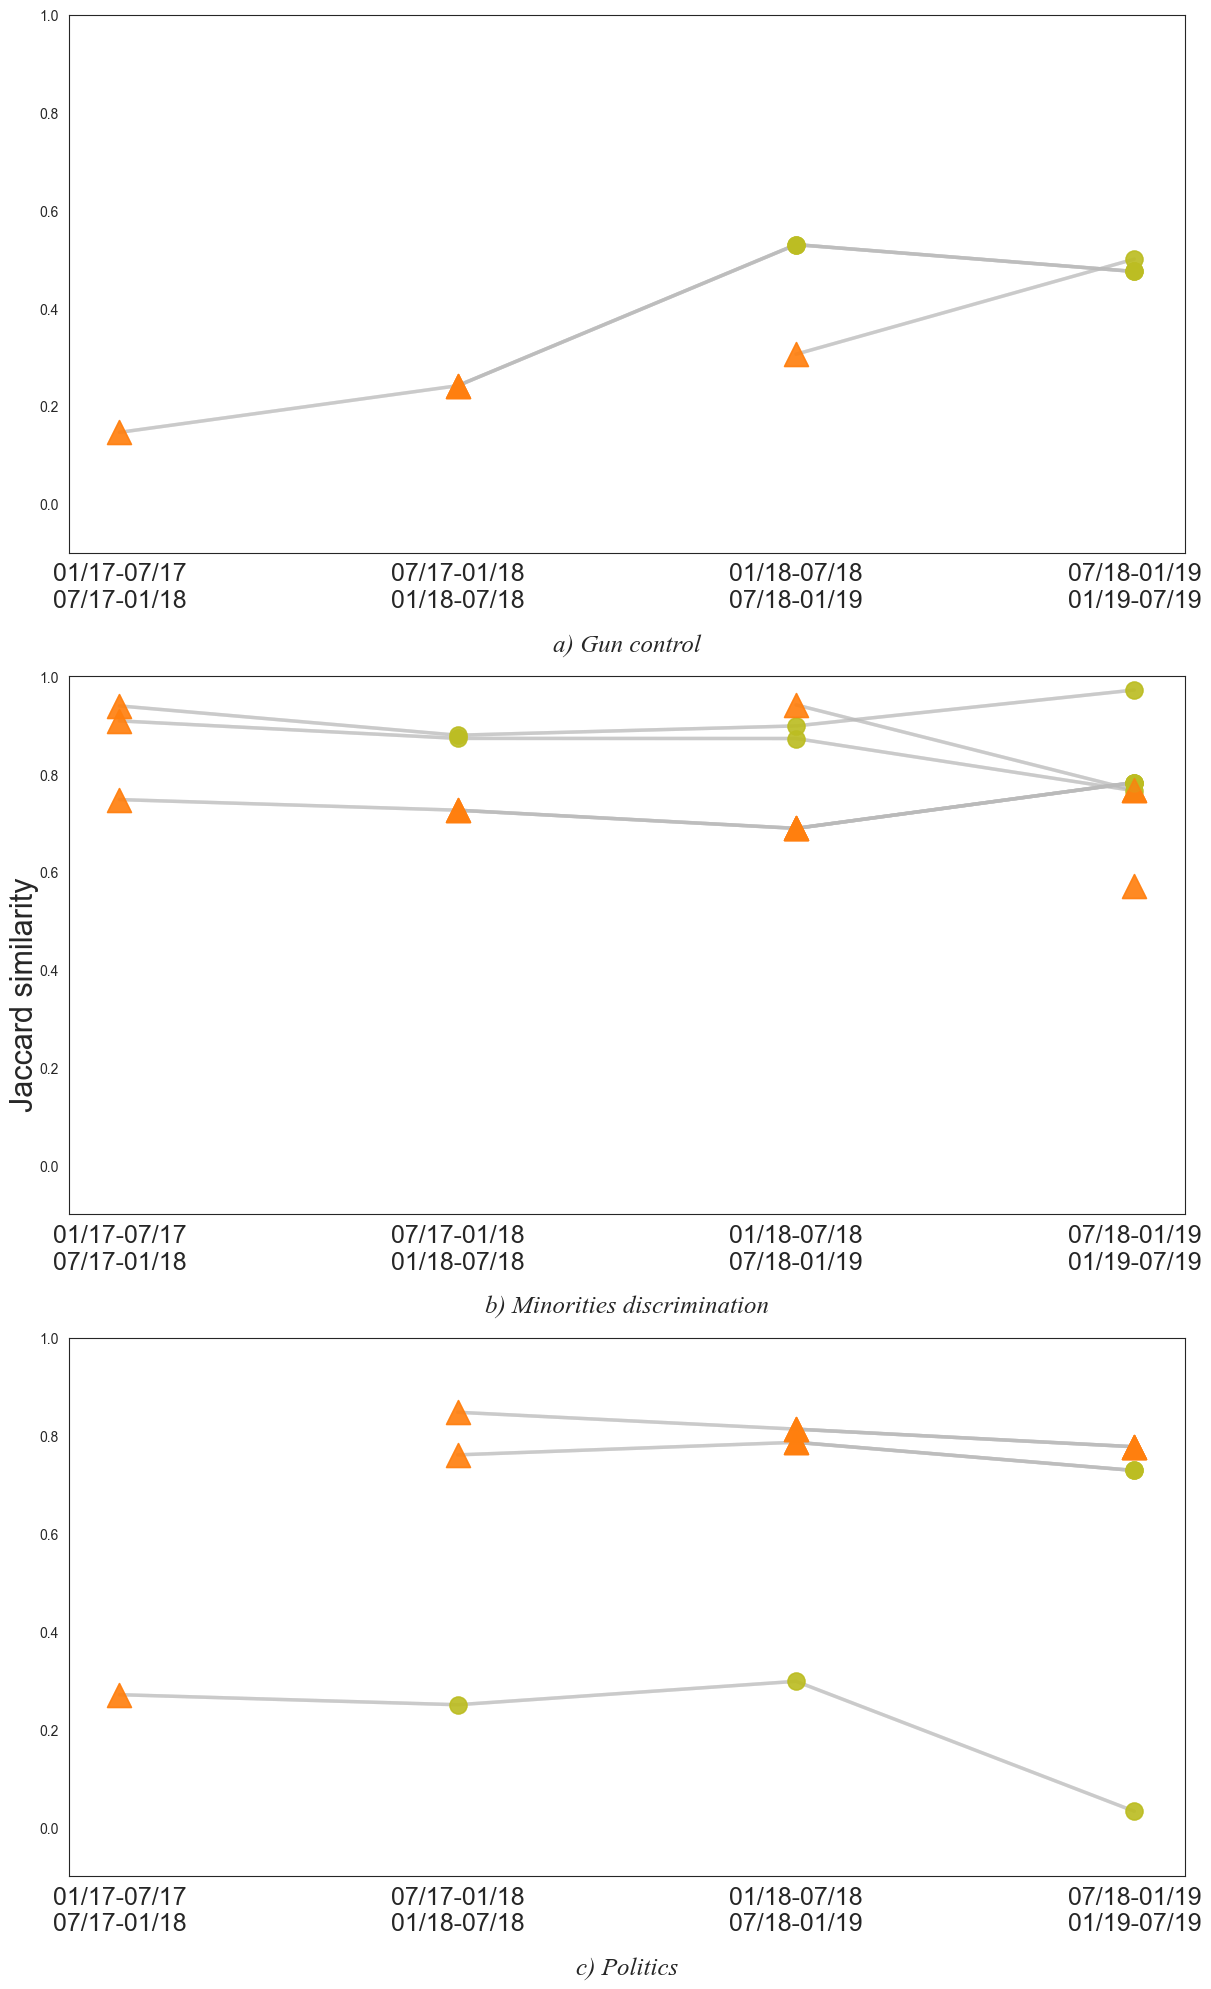

In [44]:
plot_EC_stability_single_plot(categories, "EC")

0it [00:00, ?it/s]

guncontrol [0.37435897435897436, 0.24121405750798722, 0.5296610169491526, 0.47468354430379744] ['0_0', '1_0', '2_3', '3_4', '4_4']
['.', '^', '.', '.', '.']
guncontrol [0.12244897959183673, 0.06896551724137931, 0.2130977130977131, 0.2999504214179474] ['0_1', '1_3', '2_1', '3_0', '4_0']
['.', '.', '.', '.', '^']
guncontrol [0.2808988764044944, 0.24121405750798722, 0.5296610169491526, 0.47468354430379744] ['0_2', '1_0', '2_3', '3_4', '4_4']
['.', '^', '.', '.', '.']
guncontrol [0.14790468364831552, 0.2130977130977131, 0.2999504214179474] ['1_1', '2_1', '3_0', '4_0']
['.', '.', '.', '^']
guncontrol [0.08390243902439025, 0.2860215053763441, 0.2999504214179474] ['1_2', '2_0', '3_0', '4_0']
['.', '.', '.', '^']
guncontrol [0.06896551724137931, 0.2130977130977131, 0.2999504214179474] ['1_3', '2_1', '3_0', '4_0']
['.', '.', '.', '^']
guncontrol [0.06504065040650407, 0.2860215053763441, 0.2999504214179474] ['1_4', '2_0', '3_0', '4_0']
['.', '.', '.', '^']
guncontrol [0.06212424849699399, 0.2860

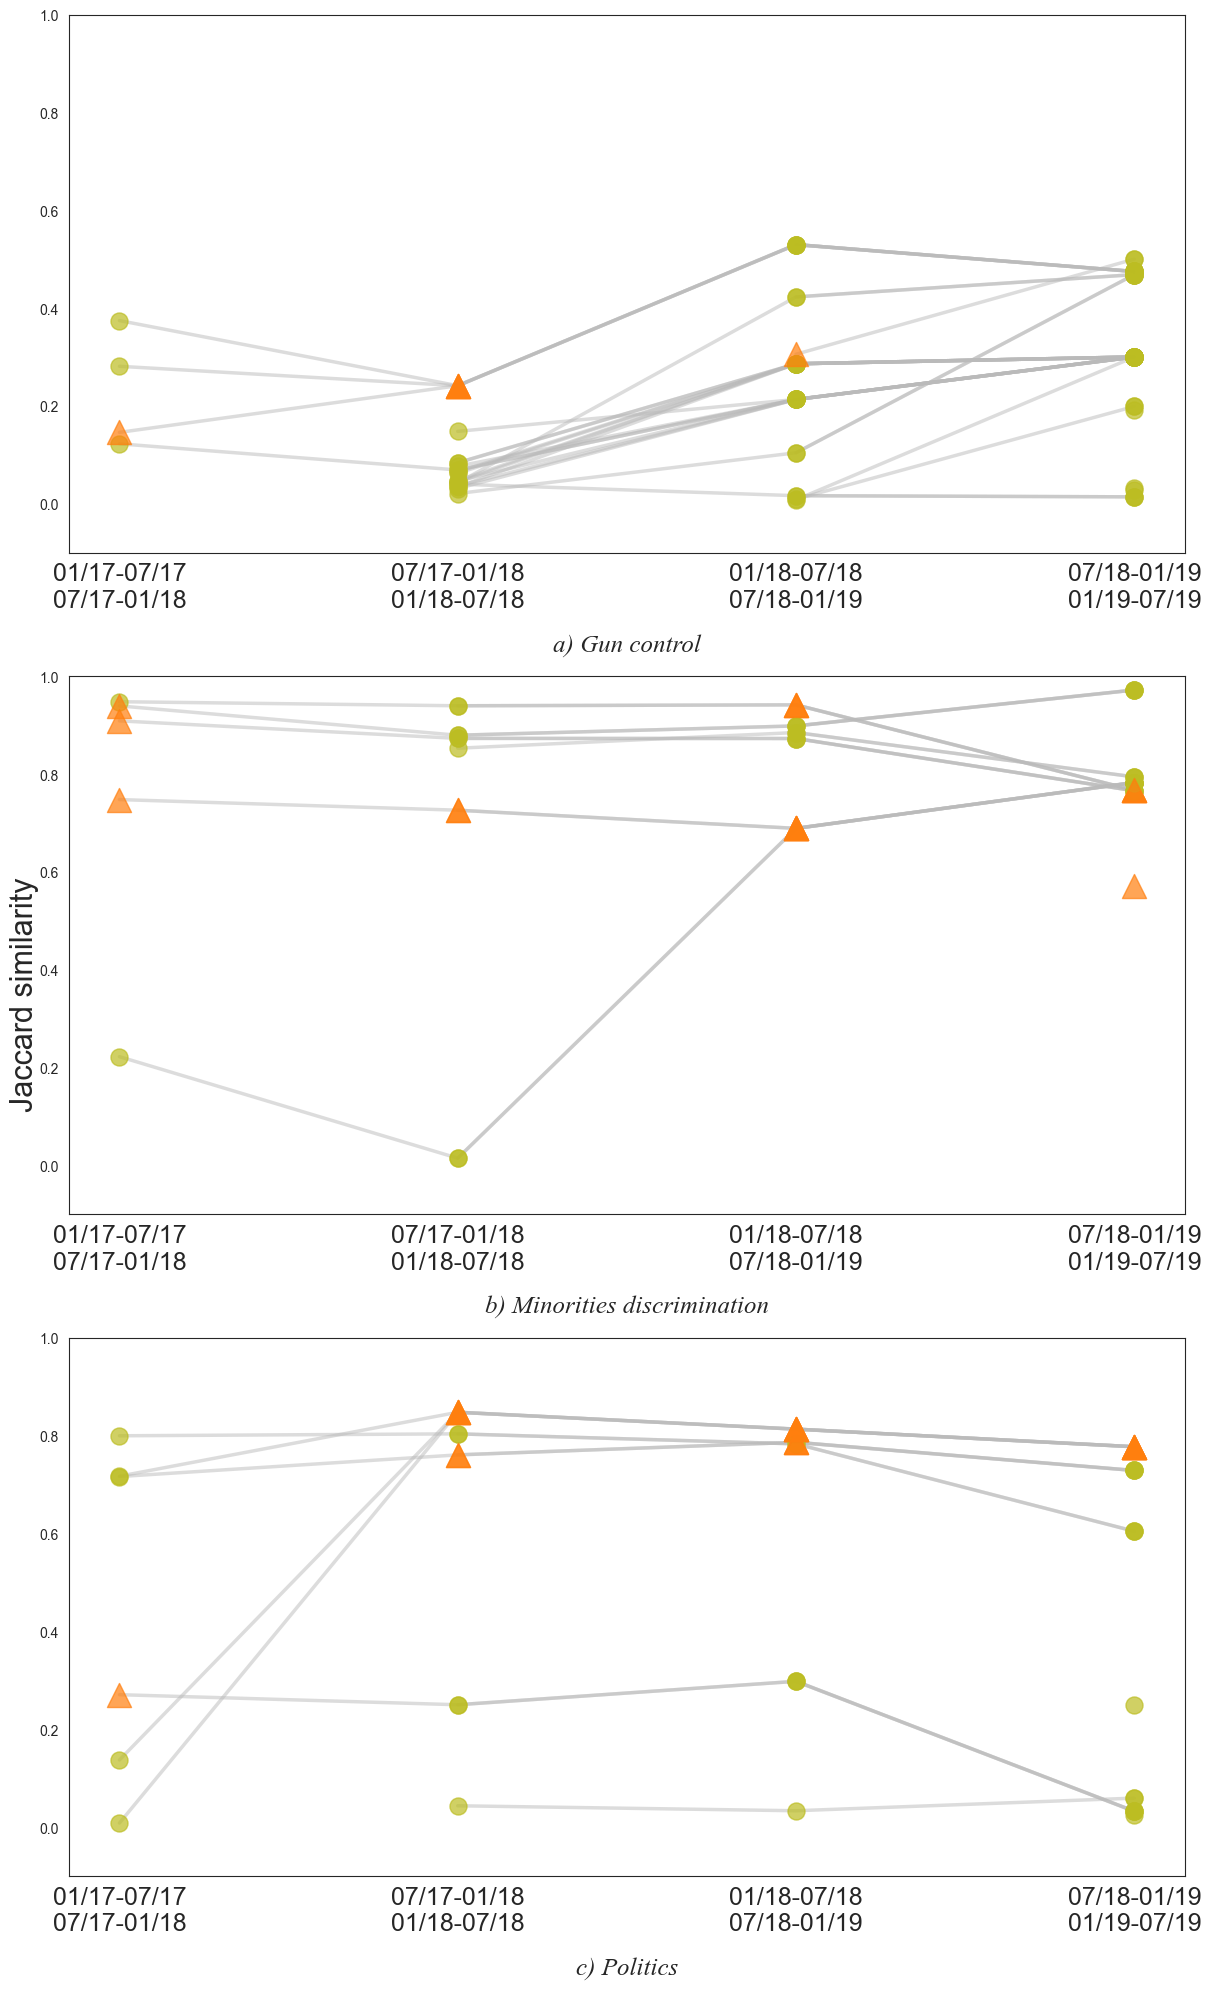

In [45]:
plot_EC_stability_single_plot(categories, "not_EC")

In [ ]:
for topic in tqdm(categories):
    df = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_ec_{topic}.csv"))
    df_ec = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_ec_{topic}.csv"))

    #retrieve non_ecs or ecs    
    df["topic"] = topic
    df = df[df["size"] >= 20].copy()
    print(f"Topic: {topic} \n")
#        df.to_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"), index = False)
    
    communities = df.community.tolist()
    ec_coms = df_ec.community.tolist()
    for com in communities:
        #if com.startswith('0'):
        if not com.startswith('4'):
            # the coms labels at t0 are the input for temporal_stability () 
            stability, timeline = temporal_stability(com, topic, communities)
            for res_com in timeline:
                print(res_com, "\n", df_ec[df_ec["community"] == res_com]["size"])                


  0%|          | 0/3 [00:00<?, ?it/s]

Topic: minority 

0_1 
 0    2143
Name: size, dtype: int64
1_1 
 Series([], Name: size, dtype: int64)
2_1 
 Series([], Name: size, dtype: int64)
3_1 
 Series([], Name: size, dtype: int64)
4_2 
 9    140
Name: size, dtype: int64
0_3 
 1    964
Name: size, dtype: int64
1_3 
 Series([], Name: size, dtype: int64)
2_3 
 Series([], Name: size, dtype: int64)
3_3 
 Series([], Name: size, dtype: int64)
4_1 
 Series([], Name: size, dtype: int64)
0_4 
 2    366
Name: size, dtype: int64
1_4 
 3    528
Name: size, dtype: int64
2_4 
 5    267
Name: size, dtype: int64
3_4 
 Series([], Name: size, dtype: int64)
4_0 
 8    168
Name: size, dtype: int64
1_4 
 3    528
Name: size, dtype: int64
2_4 
 5    267
Name: size, dtype: int64
3_4 
 Series([], Name: size, dtype: int64)
4_0 
 8    168
Name: size, dtype: int64
2_2 
 4    979
Name: size, dtype: int64
3_2 
 6    2155
Name: size, dtype: int64
4_4 
 Series([], Name: size, dtype: int64)
2_4 
 5    267
Name: size, dtype: int64
3_4 
 Series([], Name: size, d

In [ ]:
for topic in tqdm(categories):
    i = 0
    for sem in semesters:
        print("Current iteration:", i)
    # prendiamo il df delle EC per vedere l'id delle community EC
        df_community = pd.read_csv(os.path.join(src_results, f"{topic}/{ec_val}/{ec_val}_{topic}_{i}.csv"))
    #prendiamo il df degli utenti nelle community
        df_stats = pd.read_csv(os.path.join(src_results, f"{topic}/eva_users_merged_{i}_com_stats.csv"))
        df_users = df_stats
        coms_list = df_community.community.tolist()
        
        
        df_EC_users = df_users[df_users['community'].isin(coms_list)].copy()
        ec_users = df_EC_users[["user_id", "max_label"]].copy()
        # TM users' list
        ec_users.to_csv(os.path.join(src_results, f"{topic}/{ec_val}_user_TM_{topic}_{i}.csv"), index = False)
        
        
        # i post sono stati sottoposti a una lieve pulizia del testo
        period0 = datetime.datetime.strptime(sem[0], "%d/%m/%Y").strftime("%d-%m-%Y")
        period1 = datetime.datetime.strptime(sem[1], "%d/%m/%Y").strftime("%d-%m-%Y")
        filename = os.path.join(data_path, f'{topic}/{topic}_{period0}_{period1}.csv')
        df_post = pd.read_csv(filename)
        df_filtered_post = df_post[df_post["author"].isin(df_EC_users["user_id"].tolist())].copy()
        
        # author
        df_final = pd.merge(left=df_EC_users[["community", "user_id"]], right = df_filtered_post, left_on="user_id", 
                                    right_on = "author" , how = "inner")

        i+=1
     

## Dataframe for NLP analysis

In [ ]:
for topic in tqdm(categories):
    for i in range(5):
        df_EC = pd.read_csv(os.path.join(src_results, f"{topic}/EC/EC_{topic}_{i}.csv"))
        df_not_EC = pd.read_csv(os.path.join(src_results, f"{topic}/non_EC/non_EC_{topic}_{i}.csv"))
        list_EC = df_EC.community.unique()
        df_not_EC_cleaned = df_not_EC[~df_not_EC.community.isin(list_EC)]
        print(df_not_EC_cleaned.community.unique())
        df_not_EC_cleaned.to_csv(os.path.join(src_results, f"{topic}/non_EC/non_EC_{topic}_{i}_v1.csv"))

  0%|          | 0/3 [00:00<?, ?it/s]

['0_2' '0_5' '0_7']
['1_0' '1_1' '1_2' '1_3' '1_5' '1_11' '1_12' '1_13' '1_14' '1_15' '1_16'
 '1_17' '1_18']
['2_0' '2_1' '2_3' '2_6' '2_7' '2_8' '2_11']
['3_0' '3_1' '3_3' '3_4' '3_7']
['4_1' '4_3' '4_4' '4_5' '4_6' '4_7' '4_8' '4_9' '4_10' '4_11' '4_12']
['0_0' '0_1' '0_2' '0_3' '0_5' '0_6' '0_7' '0_8' '0_9' '0_11' '0_13'
 '0_15' '0_22' '0_23' '0_24' '0_25' '0_26' '0_27' '0_28' '0_29' '0_30'
 '0_31']
['1_0' '1_3' '1_4' '1_5' '1_6' '1_9' '1_11' '1_12' '1_17' '1_20' '1_29'
 '1_31' '1_32' '1_33' '1_34' '1_35' '1_36' '1_37' '1_38' '1_39' '1_40'
 '1_41' '1_42' '1_43' '1_44' '1_45']
['2_3' '2_4' '2_5' '2_6' '2_7' '2_8' '2_9' '2_10' '2_11' '2_12' '2_13'
 '2_15' '2_16' '2_17' '2_18' '2_19' '2_20' '2_24' '2_25' '2_26' '2_27'
 '2_28' '2_29']
['3_0' '3_1' '3_3' '3_4' '3_5' '3_6' '3_7' '3_8' '3_9' '3_10' '3_11'
 '3_12' '3_13' '3_14' '3_15' '3_17']
['4_0' '4_1' '4_2' '4_3' '4_4' '4_5' '4_6' '4_7' '4_8' '4_9' '4_10' '4_11'
 '4_12' '4_14' '4_15' '4_18' '4_22']
['0_0' '0_1' '0_2' '0_4' '0_5']
['1_1'

In [ ]:
user_list_up_2 = []

In [ ]:
def preprocess_df_text_pipeline(cat, ec_val):
    data_path = f"../tesi_cau/topic_comments/" 
    for topic in tqdm(categories):
        i = 0
        for sem in semesters:
            print("Current iteration:", i)
        # prendiamo il df delle EC
            df_EC = pd.read_csv(os.path.join(src_results, f"{topic}/{ec_val}/{ec_val}_{topic}_{i}.csv"))
        # global community stats + users
            df_users_original = pd.read_csv(os.path.join(src_results, f"{topic}/eva_users_merged_{i}_com_stats.csv"))
            df_users = df_users_original[(df_users_original["size"] >= 20)].copy()
            list_ECs = df_EC.community.tolist()
        #a questo punto, abbiamo solo gli utenti nelle EC
            df_EC_users = df_users[df_users['community'].isin(list_ECs)].copy()
            
            print(df_EC_users.community.unique())
            
            df_EC_users["EC"] = ec_val
            ec_users = df_EC_users[["user_id", "EC", "max_label"]].copy()
            ec_users.to_csv(os.path.join(src_results, f"{topic}/{ec_val}_user_TM_{topic}_{i}.csv"), index = False)
            # dobbiamo recuperare i dati da commenti e post
            # i commenti sono all'interno di JSON e NON sono stati ripuliti
            # i post sono stati sottoposti a una lieve pulizia del testo
            comments = list()
            list_temp_df = []
            period0 = datetime.datetime.strptime(sem[0], "%d/%m/%Y").strftime("%d-%m-%Y")
            period1 = datetime.datetime.strptime(sem[1], "%d/%m/%Y").strftime("%d-%m-%Y")
            semester_user_comments = os.path.join(f'../topic_comments/{topic}/{topic}_{period0}_{period1}/')
#             json_files = glob.glob(os.path.join(semester_user_comments, '*.json'))
#             dfs = [pd.read_json(fn, lines = True) for fn in json_files]
            json_files = [pos_json for pos_json in os.listdir(semester_user_comments) if pos_json.endswith('.json')]
            for f in json_files:
                f = load_json(os.path.join(semester_user_comments, f))
                df = pd.json_normalize(f["comments"],max_level=1)
                list_temp_df.append(df)

            df_text_users = pd.concat(list_temp_df)
            print(topic, i)
            # per risovere il problema dei commenti nella colonna sbagliata in alcuni dataset
            if topic == "minority" and i == 4:
                df_text_users.clean_text.fillna(df_text_users['body'], inplace=True)
                del df_text_users["body"]
            elif "body" in df_text_users.columns:
                df_text_users["clean_text"] = df_text_users["body"]
                del df_text_users["body"]
                  
            df_final_users = pd.merge(left=df_EC_users[["community", "user_id"]], right = df_text_users, left_on="user_id", 
                                      right_on = "author" , how = "inner")
     #       cols_to_delete_comments = "parent_id","link_id", "subreddit_id", "date", "score"]
        
        #    df_final_users.drop(cols_to_delete_comments, axis = 1, inplace = True)  
            df_final_users.to_csv(os.path.join(f"../text_data/comments/{topic}/{ec_val}_comments_{topic}_{i}.csv"), index = False)
            i+=1
     # estraiamo quindi un dataframe con la seguente struttura:
        # nome utente | subreddit | timestamp | topic | testo | post (booleani) | commento (booleani) | stats 

In [ ]:
preprocess_df_text_pipeline(categories, "EC")


  0%|          | 0/3 [00:00<?, ?it/s]

Current iteration: 0
['0_1' '0_3' '0_4']


KeyboardInterrupt: 

In [ ]:
preprocess_df_text_pipeline(categories, "non_EC")

NameError: name 'categories' is not defined

In [ ]:
def preprocess_post_text_pipeline(cat, ec_val):
    data_path = f"../topic_posts/" 
    for topic in tqdm(categories):
        i = 0
        for sem in semesters:
            print("Current iteration:", i)
        # prendiamo il df delle EC per vedere l'id delle community EC
            df_community = pd.read_csv(os.path.join(src_results, f"{topic}/{ec_val}/{ec_val}_{topic}_{i}.csv"))
        #prendiamo il df degli utenti nelle community
            df_stats = pd.read_csv(os.path.join(src_results, f"{topic}/eva_users_merged_{i}_com_stats.csv"))
            df_users = df_stats
            coms_list = df_community.community.tolist()
            
            
            df_EC_users = df_users[df_users['community'].isin(coms_list)].copy()
            ec_users = df_EC_users[["user_id", "max_label"]].copy()
            # TM users' list
            ec_users.to_csv(os.path.join(src_results, f"{topic}/{ec_val}_user_TM_{topic}_{i}.csv"), index = False)
            
            
            # i post sono stati sottoposti a una lieve pulizia del testo
            period0 = datetime.datetime.strptime(sem[0], "%d/%m/%Y").strftime("%d-%m-%Y")
            period1 = datetime.datetime.strptime(sem[1], "%d/%m/%Y").strftime("%d-%m-%Y")
            filename = os.path.join(data_path, f'{topic}/{topic}_{period0}_{period1}.csv')
            df_post = pd.read_csv(filename)
            df_filtered_post = df_post[df_post["author"].isin(df_EC_users["user_id"].tolist())].copy()
            
            # author
            df_final = pd.merge(left=df_EC_users[["community", "user_id"]], right = df_filtered_post, left_on="user_id", 
                                       right_on = "author" , how = "inner")

           # df_final.drop(cols_to_delete_posts, axis = 1, inplace = True)  
            df_final["EC_val"] = ec_val
            df_final.to_csv(os.path.join(f"../text_data/posts/{topic}/{ec_val}_post_{topic}_{i}.csv"), index = False)
            i+=1
     # estraiamo quindi un dataframe con la seguente struttura:
        # nome utente | subreddit | timestamp | topic | testo | post (booleani) | commento (booleani) | stats 

In [ ]:
preprocess_post_text_pipeline(categories, "EC")

In [ ]:
preprocess_post_text_pipeline(categories, "non_EC")

  0%|          | 0/3 [00:00<?, ?it/s]

Current iteration: 0
              user_id  max_label
4575        gatsby137  antitrump
4576  wcarterchambers  antitrump
4577     FutureAvenir  antitrump
4578      rowenkariya  antitrump
4579        hjvteffer  antitrump
...               ...        ...
7848       VirjhinBoy  antitrump
7849           hmwith  antitrump
7850       lithobolos  antitrump
7858   fuckin_bubbles  antitrump
7859  VinylAndOctavia  antitrump

[1948 rows x 2 columns]
Current iteration: 1
               user_id  max_label
0     Sherlock--Holmes   protrump
1             jblack94   protrump
2                UDT22   protrump
3           mikesteane   protrump
4          Taxus_Calyx   protrump
...                ...        ...
8811          Juyil900   protrump
8812      mairedemerde  antitrump
8813     Ignatiusloyal    neutral
8814      finiksrising    neutral
8815    nguyenkhuong92  antitrump

[8273 rows x 2 columns]
Current iteration: 2
                   user_id max_label
0               TCDWarrior  protrump
1     bre

KeyboardInterrupt: 